In [3]:
import torch
import torch.nn as nn
import torch.nn.init as init

We want to create a FeedForward Network architeciture. 

To do that, we will utilize the Module class inside torch.nn

In [4]:
class FeedForwardNN(nn.Module):

    """
    A flexible feedforward neural network.
    """

    def __init__(self, input_size, hidden1_size, hidden2_size, output_size):
        """
        Initializes all the layers of the network.

        Args:
            input_size (int): Number of features in the input data (e.g., 784 for MNIST)
            hidden1_size (int): Number of neurons in the first hidden layer
            hidden2_size (int): Number of neurons in the second hidden layer
            output_size (int): Number of output classes (e.g., 10 for digits 0-9)
        """
        # This line is mandatory for any class that inherits from nn.Module
        super(FeedForwardNN, self).__init__()

        # --- Define the Architecture ---
        # We use nn.Sequential to stack layers. This makes the
        # forward pass cleaner and is easy to modify.
        self.network = nn.Sequential(
            # Input layer to Hidden layer 1
            nn.Linear(input_size, hidden1_size),
            nn.ReLU(),

            # Hidden layer 1 to Hidden layer 2
            nn.Linear(hidden1_size, hidden2_size),
            nn.ReLU(),

            # Hidden layer 2 to Output layer
            nn.Linear(hidden2_size, output_size)
        )

        # --- Apply Weight Initialization ---
        self.apply(self._init_weights)


    def _init_weights(self, module):
        """
        Applies proper weight initialization.
        We'll use He initialization, which is a common choice for ReLU.
        """
        if isinstance(module, nn.Linear):
            # 'he_normal_' fills the tensor with values from a normal distribution
            # as described in the "He initialization" paper.
            init.kaiming_normal_(module.weight, mode='fan_in', nonlinearity='relu')

            # Initialize biases to zero (a common practice)
            if module.bias is not None:
                init.constant_(module.bias, 0)

    def forward(self, x):
        """
        Defines the forward pass.
        This is where data flows through the network.
        """

        # Because we used nn.Sequential, the forward pass
        # is just one line. It passes the input 'x'
        # through all the layers we defined.
        
        logits = self.network(x)

        # We return 'logits' (raw scores) because our chosen loss function,
        # CrossEntropyLoss, combines Softmax and NLLLoss.
        # It's more efficient and numerically stable.
        return logits

In [5]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from torchvision import datasets, transforms
import torch.nn as nn
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import torch.nn.functional as F

In [6]:
BATCH_SIZE = 64
input_dim = 784
output_dim = 10
RANDOM_SEED = 42
TEST_VALID_SIZE = 0.5

Since the data loading cell defined `train_loader` and `val_loader` directly, the reference to `DATA_LOADERS_FULL` in this cell was causing a `NameError`. Therefore, the two lines referencing `DATA_LOADERS_FULL` were removed, allowing the function to use the globally defined `train_loader` and `val_loader` variables. Since the objective is to run the model, the final lines that call `train_model` and print the results were also uncommented.

In [7]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn as nn 

# MNIST images are 28x28 PIL images, but our network needs
# [784] flattened, normalized tensors.

transform_pipeline = transforms.Compose([

    # 1. Converts the PIL Image (range [0, 255]) into a
    #    PyTorch tensor (shape [1, 28, 28], range [0.0, 1.0]).
    transforms.ToTensor(),

    # 2. Normalizes the tensor. The values (0.1307,) and (0.3081,) are
    #    the pre-calculated global mean and standard deviation of the MNIST dataset.
    #    This shifts the data range from [0, 1] to roughly [-0.4, 2.8],
    #    which helps the model train faster and more stably.
    transforms.Normalize((0.1307,), (0.3081,)),

    # 3. Flattens the [1, 28, 28] tensor into a [784] vector,
    #    which is what our input_size=784 layer expects.



transforms.Lambda(lambda x: x.flatten())
])


# PyTorch will automatically download the data to the './data' directory
# if it's not already there.

train_dataset = datasets.MNIST(
    root='./data',      # Directory to save the data
    train=True,         # Get the 60,000-sample training set
    download=True,      # Download it if not present
    transform=transform_pipeline # Apply transformations
)

val_dataset = datasets.MNIST(
    root='./data',
    train=False,        # Get the 10,000-sample test set
    download=True,
    transform=transform_pipeline
)


BATCH_SIZE = 64 # From our requirements

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True  # Shuffle training data
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False # No need to shuffle validation data
)

print(f"--- MNIST DataLoaders Created ---")
print(f"Total training samples: {len(train_dataset)}")
print(f"Total validation samples: {len(val_dataset)}")

# This confirms our data is correctly shaped for the model
X_batch_example, y_batch_example = next(iter(train_loader))

print(f"\nExample batch shapes:")
print(f"X_batch shape: {X_batch_example.shape}")
print(f"y_batch shape: {y_batch_example.shape}")

--- MNIST DataLoaders Created ---
Total training samples: 60000
Total validation samples: 10000

Example batch shapes:
X_batch shape: torch.Size([64, 784])
y_batch shape: torch.Size([64])


In [8]:
import torch
import torch.nn as nn
import torch.optim as optim


# Hyperparameters 
INPUT_DIM = 784    # 28*28 flattened MNIST images
HIDDEN1_DIM = 128 
HIDDEN2_DIM = 64   
OUTPUT_DIM = 10    # 10 classes (digits 0-9)
LEARNING_RATE = 0.01 


device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"--- Using {device} device ---")


model = FeedForwardNN(INPUT_DIM, HIDDEN1_DIM, HIDDEN2_DIM, OUTPUT_DIM).to(device)
print(model)



loss_function = nn.CrossEntropyLoss()


optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)

--- Using cpu device ---
FeedForwardNN(
  (network): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=10, bias=True)
  )
)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import time
import numpy as np

# Define number of epochs and patience
NUM_EPOCHS = 50 # Set a high number, early stopping will find the best
PATIENCE = 5    # How many epochs to wait for improvement
BEST_MODEL_PATH = "best_model.pth" # File to save the best model

def train_model_with_early_stopping(model, loss_function, optimizer, train_loader, val_loader,
                                    num_epochs, patience, save_path, device):
    """
    The main training loop function with Early Stopping.
    """

    print(f"Starting training for {num_epochs} epochs on {device}...")
    print(f"Early stopping enabled with patience = {patience}")
    start_time = time.time()

    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': []
    }

    # Early Stopping variables
    best_val_loss = np.inf
    patience_counter = 0
    best_epoch = 0

    for epoch in range(num_epochs):

        # Training Phase 
        model.train()
        running_train_loss = 0.0
        correct_train = 0
        total_train = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        epoch_train_loss = running_train_loss / total_train
        epoch_train_acc = 100 * correct_train / total_train
        history['train_loss'].append(epoch_train_loss)
        history['train_acc'].append(epoch_train_acc)


        # Validation Phase
        model.eval()
        running_val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = loss_function(outputs, labels)

                running_val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        epoch_val_loss = running_val_loss / total_val
        epoch_val_acc = 100 * correct_val / total_val
        history['val_loss'].append(epoch_val_loss)
        history['val_acc'].append(epoch_val_acc)


        # Log Progress 
        print(f"Epoch {epoch+1}/{num_epochs} | "
              f"Train Loss: {epoch_train_loss:.4f} | Train Acc: {epoch_train_acc:.2f}% | "
              f"Val Loss: {epoch_val_loss:.4f} | Val Acc: {epoch_val_acc:.2f}%")


        # Early Stopping Check
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            patience_counter = 0 # Reset patience
            best_epoch = epoch + 1
            # Save the best model weights
            torch.save(model.state_dict(), save_path)
            print(f"   -> New best model saved! Val Loss: {best_val_loss:.4f}")
        else:
            patience_counter += 1
            print(f"   -> No improvement. Patience: {patience_counter}/{patience}")
            if patience_counter >= patience:
                print(f"\n--- Early stopping triggered at epoch {epoch+1} ---")
                break # Exit the training loop

    end_time = time.time()
    print(f"\nTraining finished in {(end_time - start_time):.2f} seconds.")

    print(f"Loading best model from epoch {best_epoch} (Val Loss: {best_val_loss:.4f})")
    model.load_state_dict(torch.load(save_path))

    return history

training_history = train_model_with_early_stopping(
    model,
    loss_function,
    optimizer,
    train_loader,
    val_loader,
    NUM_EPOCHS,
    PATIENCE,
    BEST_MODEL_PATH,
    device
)

print("\nTraining complete!")
print(f"Final model is the best model from epoch {training_history['val_loss'].index(min(training_history['val_loss'])) + 1}.")


Training complete!


In [ ]:
print(training_history)

{'train_loss': [0.4408403079032898, 0.2160606868783633, 0.17018077589670816, 0.14372837900916735, 0.1254635875125726, 0.11186255576014519, 0.10058877486089865, 0.09168068054219088, 0.08405347805817923, 0.07735553481429815, 0.07160521099915107, 0.06644156880527735, 0.06207042988936106, 0.05777990523477396, 0.053720705637335775, 0.050542102286219595, 0.04736869153231382, 0.044192587452133496, 0.041613623874882856, 0.039182923687249425, 0.03687621327750385, 0.0348482533827424, 0.03271473772674799, 0.03078959790406128, 0.02901118614859879, 0.027376159440601865, 0.025763626096459727, 0.024588496736064554, 0.02310993256829679, 0.0217641002861162], 'train_acc': [86.865, 93.65, 95.03166666666667, 95.775, 96.27833333333334, 96.69833333333334, 97.08, 97.32, 97.54666666666667, 97.73333333333333, 97.90333333333334, 98.09, 98.23666666666666, 98.335, 98.525, 98.59, 98.70333333333333, 98.86, 98.91333333333333, 99.01666666666667, 99.05333333333333, 99.12833333333333, 99.20833333333333, 99.275, 99.3216

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# (Assuming training_history exists from the previous cell)

# Get the data from the history dictionary
train_loss = training_history['train_loss']
val_loss = training_history['val_loss']
train_acc = training_history['train_acc']
val_acc = training_history['val_acc']

# Create an array for the x-axis (epochs)
epochs = range(1, len(train_loss) + 1)

# Training & Validation Loss

plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss, 'b-o', label='Training Loss')
plt.plot(epochs, val_loss, 'r-s', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


# Training & Validation Accuracy 

plt.figure(figsize=(10, 5))
plt.plot(epochs, train_acc, 'b-o', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-s', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.show()

NameError: name 'training_history' is not defined

In [ ]:
test_dataset = datasets.MNIST(
    root='./data',
    train=False,        # <-- IMPORTANT: train=False
    download=True,
    transform=transform_pipeline # Use the CNN-friendly transform
)

# --- 2. Create the test_loader ---
# We use the same BATCH_SIZE. shuffle=False is critical.
test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE, # From your previous cells
    shuffle=False       # Never shuffle a test set
)

print(f"--- Test Loader Created ---")
print(f"Total test samples: {len(test_dataset)}")

--- Test Loader Created ---
Total test samples: 10000



FINAL TEST ACCURACY: 92.25%

--- Generating Confusion Matrix ---


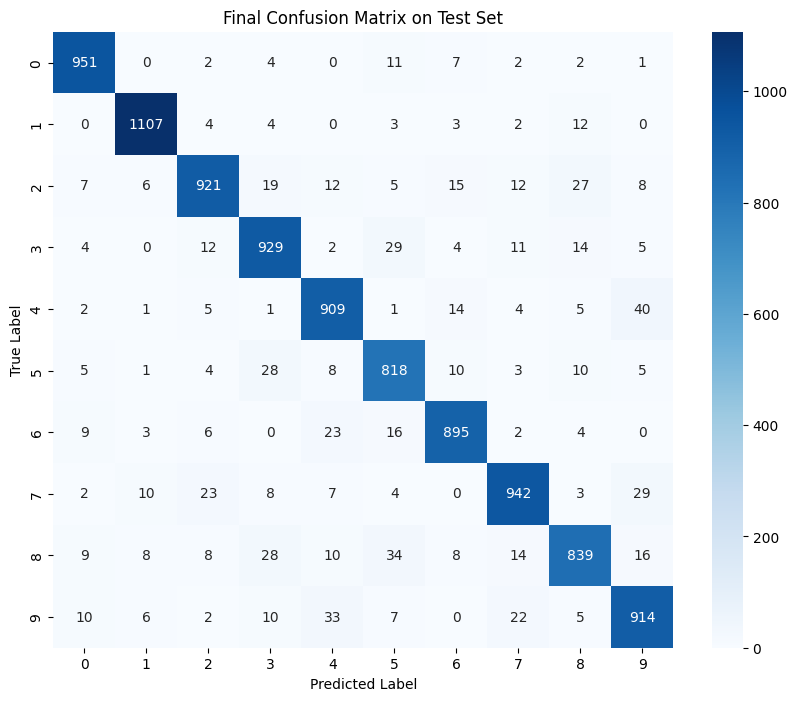

In [ ]:

from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns

def evaluate_on_test_set(model, test_loader, device):
    """
    Evaluates the model on the test set.
    Returns final accuracy, all predictions, and all true labels.
    """
    model.eval() # Set to evaluation mode (turns off Dropout/BN updates)
    all_labels = []
    all_predictions = []
    
    with torch.no_grad(): # Disable gradient calculation
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            
            # Get predictions
            _, predicted = torch.max(outputs.data, 1)
            
            # Store predictions and labels to build confusion matrix
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate final accuracy
    accuracy = 100 * accuracy_score(all_labels, all_predictions)
    
    return accuracy, all_labels, all_predictions

# --- Run the Evaluation ---
test_accuracy, y_true, y_pred = evaluate_on_test_set(model, test_loader, device)

print(f"\nFINAL TEST ACCURACY: {test_accuracy:.2f}%")

# 4. Generate and Plot Confusion Matrix
print("\n--- Generating Confusion Matrix ---")
cm = confusion_matrix(y_true, y_pred)
class_names = [str(i) for i in range(10)] # Labels 0-9

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Final Confusion Matrix on Test Set')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

C1. Learning Rate Analysis
First, we analyze the effect of the learning rate. A rate that is too low will converge very slowly, while one that is too high can become unstable and fail to converge at all.

Baseline: Batch Size = 64, Architecture = [128, 64] Variable: Learning Rate = [0.001, 0.01, 0.1, 1.0]

In [ ]:
# Define Experiment Parameters 
learning_rates = [0.001, 0.01, 0.1, 1.0]
lr_histories = {} # To store results



for lr in learning_rates:
    print(f"\n--- Training with Learning Rate: {lr} ---")
    
    # 1. Create a NEW model instance (baseline architecture)
    model = FeedForwardNN(INPUT_DIM, HIDDEN1_DIM, HIDDEN2_DIM, OUTPUT_DIM).to(device)
    
    # 2. Create the loss function
    loss_function = nn.CrossEntropyLoss()
    
    # 3. Create a NEW optimizer with the test learning rate
    optimizer = optim.SGD(model.parameters(), lr=lr)
    
    # 4. Define a unique save path
    save_path = f"best_model_lr_{lr}.pth"
    
    # 5. Run the training (using the original BS=64 loaders)
    history = train_model_with_early_stopping(
        model, 
        loss_function, 
        optimizer, 
        train_loader,  # Baseline BS=64 loader
        val_loader,    # Baseline BS=64 loader
        NUM_EPOCHS, 
        PATIENCE, 
        save_path, 
        device
    )
    
    # 6. Store the history
    lr_histories[lr] = history

print("\n--- Learning Rate Experiment Complete ---")


--- Training with Learning Rate: 0.001 ---
Starting training for 50 epochs on cpu...
Early stopping enabled with patience = 5
Epoch 1/50 | Train Loss: 1.1720 | Train Acc: 63.96% | Val Loss: 0.6691 | Val Acc: 80.92%
   -> New best model saved! Val Loss: 0.6691
Epoch 2/50 | Train Loss: 0.5683 | Train Acc: 83.83% | Val Loss: 0.4653 | Val Acc: 86.64%
   -> New best model saved! Val Loss: 0.4653
Epoch 3/50 | Train Loss: 0.4402 | Train Acc: 87.38% | Val Loss: 0.3859 | Val Acc: 88.82%
   -> New best model saved! Val Loss: 0.3859
Epoch 4/50 | Train Loss: 0.3798 | Train Acc: 89.12% | Val Loss: 0.3440 | Val Acc: 90.00%
   -> New best model saved! Val Loss: 0.3440
Epoch 5/50 | Train Loss: 0.3431 | Train Acc: 90.16% | Val Loss: 0.3169 | Val Acc: 90.61%
   -> New best model saved! Val Loss: 0.3169


In [ ]:
plt.figure(figsize=(10, 6))

for lr, history in lr_histories.items():
    plt.plot(history['val_loss'], label=f'LR = {lr}')

plt.title('Learning Rate Analysis: Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.legend()
plt.grid(True)
plt.ylim(0, 1.0) # Set Y-limit to zoom in on convergence 
plt.show()